In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily

try: #spelling depends on enviroment version 
    import urllib2 as urllib #URL handling module
except ImportError:
    import urllib.request as urllib
import json

sns.set_theme(style="whitegrid")

### Dataset

1. Charging Station Data API: https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/ 

2. NYC ZIPCODE: NYC OPEN DATA

3. Arterial Highways and Major Streets: NYC Dept of City Planning

In [71]:
zipcode = gpd.read_file('modified_zipcode.geojson')

def StationAPI(key, access):
    url = "https://developer.nrel.gov/api/alt-fuel-stations/v1.json?status=E&access={}&state=NY&fuel_type=ELEC&api_key={}".format(access,key)

    data = urllib.urlopen(url).read().decode('utf-8')
    data = json.loads(data)

    df = pd.DataFrame(data['fuel_stations'])
    df_ny = df[df['zip'].apply(lambda s: int(s) in zipcode['MODZCTA'].tolist())]

    ### clean dataset
    df_ny = df_ny.loc[:, ~df_ny.columns.isin(['status_code','fuel_type_code','state','country','intersection_directions','station_phone',
                                                   'ev_renewable_source','ev_other_evse','maximum_vehicle_class','ev_network_web','owner_type_code'])]

    filter_col = []
    for col in df_ny.columns:
        if (df_ny[col].isnull().sum() == len(df_ny)):
            filter_col.append(col)
    df_ny = df_ny.loc[:, ~df_ny.columns.isin(filter_col)]

    #remove French columns
    df_ny = df_ny[ [i for i in df_ny.columns if '_fr' not in i] ]

    #adjust fed agency
    if 'federal_agency' in df_ny.columns:
        df_ny['federal_agency'] = df_ny['federal_agency'].apply(lambda s: s['name'] if s==s else s)

    # fillna
    df_ny['ev_level2_evse_num'] = df_ny['ev_level2_evse_num'].fillna(0)
    df_ny['ev_dc_fast_num'] = df_ny['ev_dc_fast_num'].fillna(0)
    df_ny['open_date'] = pd.to_datetime(df_ny['open_date'])

    return df_ny

In [72]:
key="your_KEY"

private_ny = StationAPI(key, "private")
public_ny = StationAPI(key, "public")

### Private Charging Stations (Non-residential)
1. Number of Private Stations

2. EV ports and connector types (Outlier value)

3. Facility Types (particularly Federal Government and Office Buildings)

In [73]:
print('{} non-residential private stations are recorded'.format(len(private_ny)))
private_ny.head()

37 non-residential private stations are recorded


,access_code,access_days_time,access_detail_code,cards_accepted,date_last_confirmed,groups_with_access_code,id,open_date,facility_type,station_name,...,city,street_address,zip,ev_connector_types,ev_dc_fast_num,ev_level2_evse_num,ev_network,ev_pricing,ev_workplace_charging,federal_agency
3,private,Accepts fleet card,GOVERNMENT,None,2024-01-10,Private - Government only,41240,2021-01-15,HOSPITAL,James J Peters VA Medical Center,...,Bronx,130 W Kingsbridge Rd,10468,[J1772],0.0,2.0,Non-Networked,$0.13 per kWh,False,Department of Veterans Affairs
21,private,None,None,None,2024-02-12,Private,44324,2011-11-30,CAR_DEALER,Star Nissan,...,Bayside,20602 Northern Blvd,11361,[J1772],0.0,1.0,Non-Networked,None,False,NaN
23,private,None,None,None,2024-02-12,Private,44328,2011-11-30,CAR_DEALER,Bay Ridge Nissan,...,Brooklyn,6501 5th Ave,11220,[J1772],0.0,1.0,Non-Networked,None,False,NaN
24,private,None,None,None,2024-02-12,Private,44330,2011-11-30,CAR_DEALER,Kings Nissan,...,Brooklyn,2758 Coney Island Ave,11235,[J1772],0.0,1.0,Non-Networked,None,False,NaN
39,private,None,None,None,2024-02-12,Private,49939,2012-10-25,CAR_DEALER,Nissan of Queens,...,Ozone Park,9325 Rockaway Blvd,11417,[J1772],0.0,1.0,Non-Networked,None,False,NaN


There are 1 private DC fast charging hub and 36 hubs with private Level 2


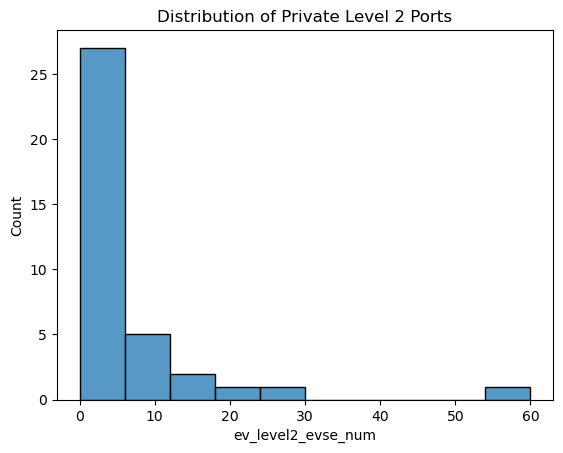

EV Connector Types:  ['J1772', 'J1772COMBO,TESLA']


In [74]:
### EV ports and connector
private_dc = len(private_ny[private_ny['ev_dc_fast_num']!=0])
private_l2 = len(private_ny[private_ny['ev_level2_evse_num']!=0])
print("There are {} private DC fast charging hub and {} hubs with private Level 2".format(private_dc, private_l2))

sns.histplot(private_ny.ev_level2_evse_num,bins=10).set_title("Distribution of Private Level 2 Ports")
plt.show()

print('EV Connector Types: ', private_ny['ev_connector_types'].apply(lambda s: ','.join(s)).unique().tolist())

In [75]:
## station with the most level 2 private charging ports
private_ny[private_ny['ev_level2_evse_num'] == private_ny['ev_level2_evse_num'].max()][['station_name','city','facility_type',
                                                                                       'zip','ev_connector_types','ev_dc_fast_num','ev_level2_evse_num',
                                                                                       'ev_network']]

,station_name,city,facility_type,zip,ev_connector_types,ev_dc_fast_num,ev_level2_evse_num,ev_network
126,DHL - Long Island City,Jamaica,FLEET_GARAGE,11413,[J1772],0.0,60.0,POWERFLEX


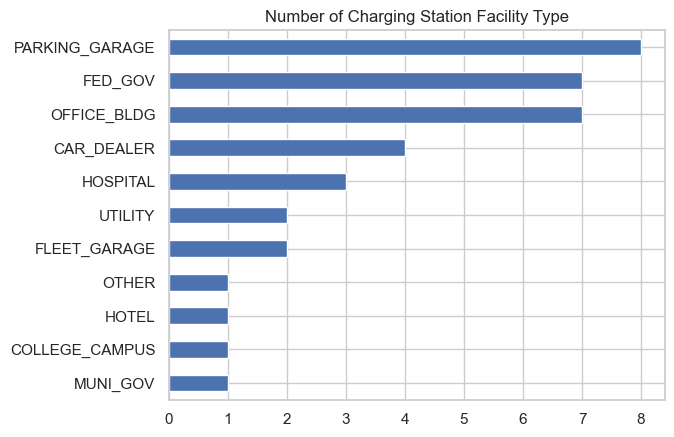

In [129]:
### Facility Type
private_ny['facility_type'].value_counts().sort_values().plot.barh().set_title("Number of Charging Station Facility Type")
plt.show()

In [77]:
### Facility Type: Federal Goverment 
private_ny[private_ny['facility_type']=='FED_GOV'][['station_name','city','facility_type','zip','ev_connector_types',
                                                    'ev_dc_fast_num','ev_level2_evse_num','ev_network','federal_agency']]

,station_name,city,facility_type,zip,ev_connector_types,ev_dc_fast_num,ev_level2_evse_num,ev_network,federal_agency
50,Environmental Protection Agency,New York,FED_GOV,10007,[J1772],0.0,5.0,Non-Networked,U.S. Environmental Protection Agency
133,VISN 2/NYHHCS/MANHATTAN,New York,FED_GOV,10010,[J1772],0.0,1.0,Non-Networked,Department of Veterans Affairs
134,FLUSHING,Queens,FED_GOV,11355,[J1772],0.0,2.0,Non-Networked,U.S. Postal Service
135,BOULEVARD (HUNTS POINT),The Bronx,FED_GOV,10459,[J1772],0.0,2.0,Non-Networked,U.S. Postal Service
139,ANSONIA,New York,FED_GOV,10023,[J1772],0.0,5.0,Non-Networked,U.S. Postal Service
140,MOTT HAVEN,The Bronx,FED_GOV,10459,[J1772],0.0,5.0,Non-Networked,U.S. Postal Service
141,MANHATTAN VMF,New York,FED_GOV,10001,[J1772],0.0,15.0,Non-Networked,U.S. Postal Service


In [78]:
private_ny[private_ny['facility_type']=='OFFICE_BLDG'][['station_name','city','facility_type','zip','ev_connector_types',
                                                    'ev_dc_fast_num','ev_level2_evse_num','ev_network','federal_agency']]

,station_name,city,facility_type,zip,ev_connector_types,ev_dc_fast_num,ev_level2_evse_num,ev_network,federal_agency
48,Spectrum,Staten Island,OFFICE_BLDG,10303,[J1772],0.0,2.0,EV Connect,NaN
62,Company,New York,OFFICE_BLDG,10017,[J1772],0.0,5.0,EV Connect,NaN
66,Verizon - Manhattan,Manhattan,OFFICE_BLDG,10036,[J1772],0.0,2.0,Non-Networked,NaN
84,Dock72,Brooklyn,OFFICE_BLDG,11205,[J1772],0.0,24.0,Non-Networked,NaN
161,Verizon - West Bronx,West Bronx,OFFICE_BLDG,10468,[J1772],0.0,4.0,Non-Networked,NaN
177,Briar Oaks,The Bronx,OFFICE_BLDG,10471,[J1772],0.0,12.0,AMPUP,NaN
195,Skanska,Queens,OFFICE_BLDG,11370,[J1772],0.0,10.0,AMPUP,NaN


### Public Charging Stations (DC, Level 2)
1. Number of Stations (Tesla and Non-Tesla)

2. EV ports and connector types (Outlier value)

3. Spatial Distribution

4. Facility Types 

In [139]:
print(public_ny.columns)

#major street
street = gpd.read_file("nyc_major_street.json")

def TeslaNotTesla(public_df, type):
    ## Level 2 Tesla: Tesla Destination / DC Tesla: Tesla or Tesla Supercharger
    public_df['tesla'] = public_df['ev_network'].apply(lambda s: 'Tesla' if 'Tesla' in s else 'Non-Tesla')
    pivot_stacked_tesla = pd.pivot_table(public_df[['open_date','tesla']], values='tesla', index=public_df['open_date'].dt.year,
                                        columns='tesla', aggfunc='count', fill_value=0)
    pivot_stacked_tesla.plot.bar(figsize=(8,5), stacked=True, title='Public {} Openings by Year'.format(type))
    plt.show()

    return public_df['tesla'].value_counts()


def TopNStation(public_df, col, bins_num, N):
    # Initialize the matplotlib figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize = (15, 4))

    sns.histplot(ax=ax[0],data=public_df[col],bins=bins_num).set_title("Distribution of Public {} Ports".format(col.split('_')[1].upper()))

    count_df = public_df.groupby(by=['ev_network']).count()['station_name'].reset_index().sort_values("station_name", ascending=False)
    sns.barplot(ax=ax[1], x="station_name", y="ev_network", data=count_df)

    # Add a legend and informative axis label
    ax[1].set(ylabel="",xlabel="Number of EV Stations",title="Public {} EV Network".format(col.split('_')[1].upper()))
    sns.despine(left=True, bottom=True)
    return public_df.sort_values(by=[col], ascending=False)[['station_name','zip',col,'ev_network','open_date','facility_type']].iloc[:N]


def StationMap(zipcode, public_df, street, dcfc=False):
    public_gpd = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(public_df.longitude, public_df.latitude, crs="EPSG:4326"), data=public_df
    )

    if dcfc:
        ev_col = 'ev_dc_fast_num'
        title = 'Distribution of Public DC '
        tesla_name = 'Tesla'
    else:
        ev_col = 'ev_level2_evse_num'
        title = 'Distribution of Public Level2 '
        tesla_name = 'Tesla Destination'

    _, ax = plt.subplots(nrows=1, ncols=2, figsize = (12, 8))
    for i, df, t in zip(range(len(ax)), 
                            [public_gpd[public_gpd['ev_network']!=tesla_name], public_gpd[public_gpd['ev_network']==tesla_name]], 
                            ['Tesla', 'Non-Tesla']):
        zipcode.plot(ax=ax[i], color="lightblue", zorder=i+1)
        ax[i].set_axis_off()
        if dcfc:
            street[(street['Route_Type']=='Arterial Highway') & (street['Route_Status']!='Proposed')].plot(ax=ax[i], color="tomato", zorder=i+1)
        df.plot(ax=ax[i], markersize=df[ev_col]*5, color="lightgreen", edgecolor='black', linewidth = 1, 
                legend=True, legend_kwds={'loc':'lower right'}, zorder=i+1)
        ax[i].set_title(title + t + ' Stations')

    plt.show()


Index(['access_code', 'access_days_time', 'access_detail_code',
       'cards_accepted', 'date_last_confirmed', 'groups_with_access_code',
       'id', 'open_date', 'restricted_access', 'facility_type', 'station_name',
       'updated_at', 'geocode_status', 'latitude', 'longitude', 'city',
       'street_address', 'zip', 'ev_connector_types', 'ev_dc_fast_num',
       'ev_level2_evse_num', 'ev_network', 'ev_pricing',
       'ev_workplace_charging', 'ev_network_ids'],
      dtype='object')


#### Public DC Charging Stations

In [124]:
# number of stations, tesla/non-tesla stations, construction trends
dcfc_ny = public_ny[public_ny['ev_dc_fast_num']!=0][['station_name', 'zip', 'ev_dc_fast_num', 'ev_network', 'ev_connector_types', 'geocode_status',
                                                       'latitude', 'longitude', 'open_date', 'facility_type']]

print('{} public DC stations are recorded'.format(len(dcfc_ny)))
dcfc_ny.head()

43 public DC stations are recorded


,station_name,zip,ev_dc_fast_num,ev_network,ev_connector_types,geocode_status,latitude,longitude,open_date,facility_type
86,Koeppel Nissan,11372,1.0,Non-Networked,"[CHADEMO, J1772, J1772COMBO]",200-9,40.755072,-73.892094,2017-03-01,CAR_DEALER
123,Mott Street Parking - Tesla Supercharger,10013,2.0,Tesla,[TESLA],200-9,40.717522,-73.997302,2018-07-23,None
124,W 75th Parking Garage - Tesla Supercharger,10023,4.0,Tesla,[TESLA],200-8,40.780976,-73.980414,2018-07-23,None
125,E 47th Street - Tesla Supercharger,10017,4.0,Tesla,[TESLA],200-9,40.753356,-73.971685,2018-07-23,None
514,59 Allen Street - Tesla Supercharger,10002,4.0,Tesla,[TESLA],GPS,40.717153,-73.991869,2018-12-01,PARKING_LOT


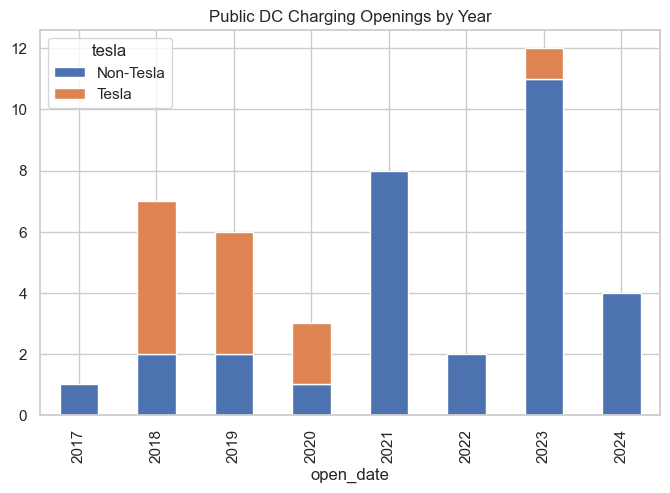

Non-Tesla    31
Tesla        12
Name: tesla, dtype: int64

In [125]:
TeslaNotTesla(dcfc_ny, 'DC Charging')

EV Connector Types:  ['CHADEMO,J1772,J1772COMBO', 'TESLA', 'J1772,J1772COMBO', 'CHADEMO,J1772COMBO', 'J1772COMBO', 'J1772COMBO,TESLA']


,station_name,zip,ev_dc_fast_num,ev_network,open_date,facility_type
1937,Revel Brooklyn Superhub,11206,50.0,EVGATEWAY,2021-08-29,PARKING_LOT
3348,Dime,11211,15.0,REVEL,2023-05-01,PARKING_GARAGE
3518,Starbucks - Tesla Supercharger,11224,12.0,Tesla,2023-11-30,PARKING_LOT
809,Outerbridge Commons - Tesla Supercharger,10309,12.0,Tesla,2020-01-20,SHOPPING_CENTER
724,Mall at Bay Plaza - Tesla Supercharger,10475,12.0,Tesla,2019-09-30,None


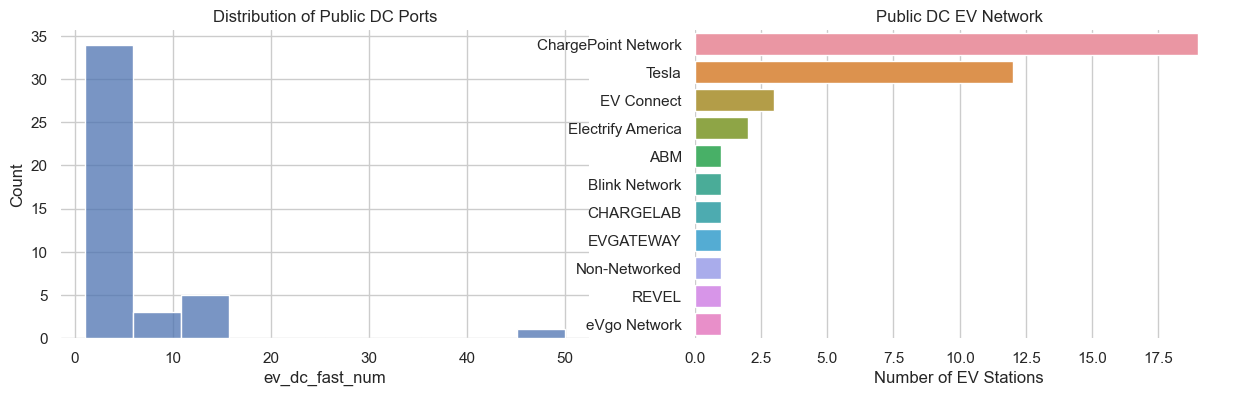

In [126]:
## EV ports and connectors
print('EV Connector Types: ', dcfc_ny['ev_connector_types'].apply(lambda s: ','.join(s)).unique().tolist())
TopNStation(dcfc_ny, 'ev_dc_fast_num', 10, 5)

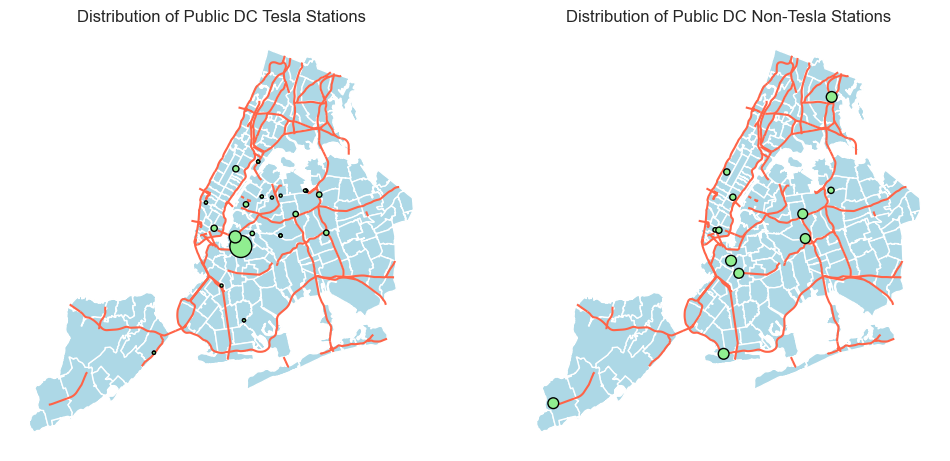

In [140]:
## Spatial Distribution
StationMap(zipcode, dcfc_ny, street, dcfc=True)

PARKING_LOT           3
SHOPPING_CENTER       2
CAR_DEALER            1
STANDALONE_STATION    1
PARKING_GARAGE        1
Name: facility_type, dtype: int64


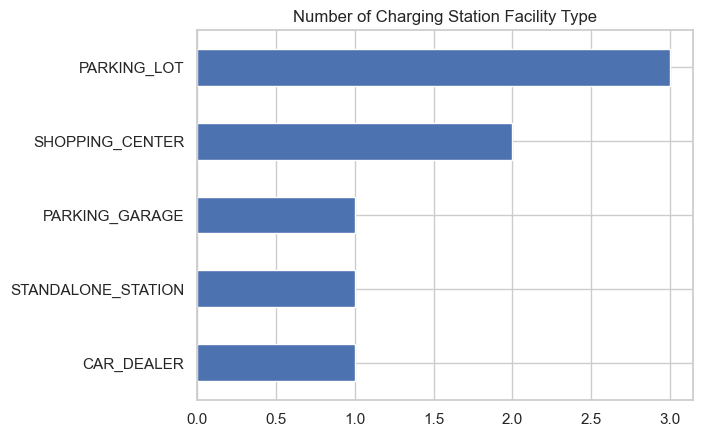

In [145]:
## Facility Type
print(dcfc_ny['facility_type'].value_counts())
dcfc_ny['facility_type'].value_counts().sort_values().plot.barh().set_title("Number of Charging Station Facility Type")
plt.show()

In [132]:
## SHOPPING_CENTER
dcfc_ny[dcfc_ny['facility_type']=='SHOPPING_CENTER'][['station_name','facility_type','zip','ev_connector_types',
                                                        'ev_dc_fast_num','ev_network']]

,station_name,facility_type,zip,ev_connector_types,ev_dc_fast_num,ev_network
515,Queens Center - Tesla Supercharger,SHOPPING_CENTER,11373,[TESLA],10.0,Tesla
809,Outerbridge Commons - Tesla Supercharger,SHOPPING_CENTER,10309,[TESLA],12.0,Tesla


#### Public Level 2 / Destination Stations

In [133]:
# number of stations, tesla/non-tesla stations, construction trends
level2_ny = public_ny[public_ny['ev_level2_evse_num']!=0][['station_name', 'zip', 'ev_level2_evse_num', 'ev_network', 'ev_connector_types', 'geocode_status',
                                                       'latitude', 'longitude', 'open_date', 'facility_type']]

print('{} public DC stations are recorded'.format(len(level2_ny)))
level2_ny.head()

627 public DC stations are recorded


,station_name,zip,ev_level2_evse_num,ev_network,ev_connector_types,geocode_status,latitude,longitude,open_date,facility_type
20,Star Nissan,11361,1.0,Non-Networked,[J1772],200-8,40.758245,-73.776954,2011-11-30,CAR_DEALER
22,Kings Nissan,11235,1.0,Non-Networked,[J1772],200-9,40.589167,-73.960707,2011-11-30,CAR_DEALER
38,Nissan of Queens,11417,1.0,Non-Networked,[J1772],200-8,40.681060,-73.845540,2012-10-25,CAR_DEALER
58,Dana Ford Lincoln,10314,1.0,Non-Networked,[J1772],GPS,40.587162,-74.194747,2014-11-01,CAR_DEALER
67,Bay Ridge Municipal Parking Garage,11209,5.0,EV Connect,[J1772],GPS,40.621698,-74.025670,2015-06-01,None


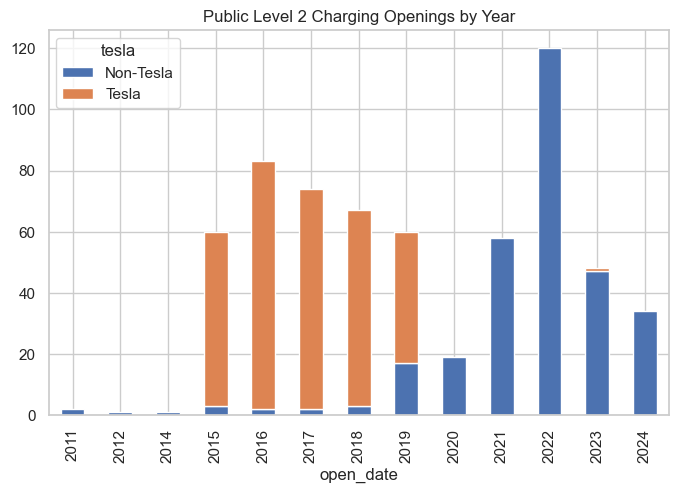

Tesla        318
Non-Tesla    309
Name: tesla, dtype: int64

In [134]:
TeslaNotTesla(level2_ny, 'Level 2 Charging')

EV Connector Types:  ['J1772', 'CHADEMO,J1772,J1772COMBO', 'TESLA', 'J1772,TESLA', 'J1772,J1772COMBO']


,station_name,zip,ev_level2_evse_num,ev_network,open_date,facility_type
3808,(SP+) - 101 Lincoln Ave. Garage,10454,50.0,FLASH,2024-04-25,PUBLIC
3248,Queens Borough Hall Municipal Parking Garage,11415,31.0,EV Connect,2023-06-01,None
2799,LGA Airpark,11369,20.0,LIVINGSTON,2022-08-23,None
3116,444 Clinton,11238,11.0,Blink Network,2023-03-30,None
3705,SWTCH Energy Inc.,11206,10.0,SWTCH,2024-01-08,MULTI_UNIT_DWELLING


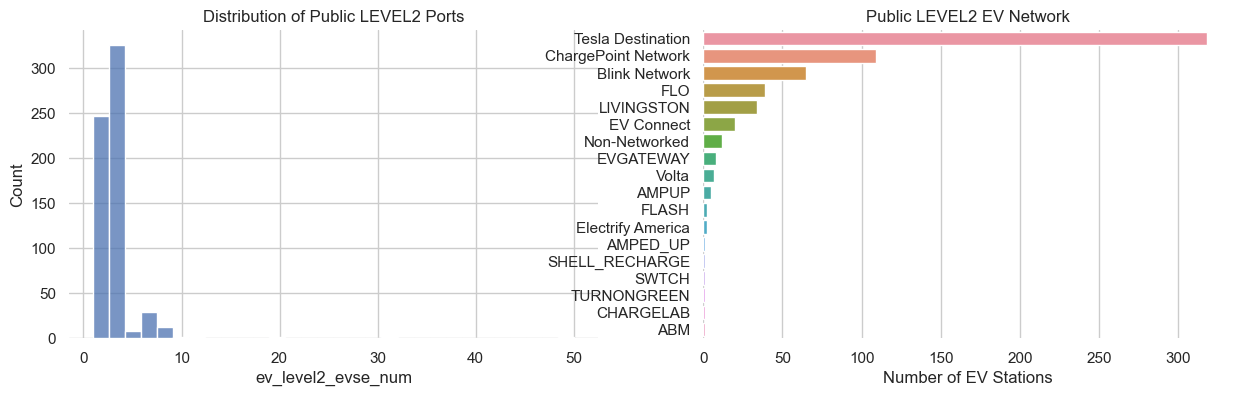

In [138]:
## EV ports and connectors
print('EV Connector Types: ', level2_ny['ev_connector_types'].apply(lambda s: ','.join(s)).unique().tolist())
## Top5 Number of Ports
TopNStation(level2_ny, 'ev_level2_evse_num', 30, 5)

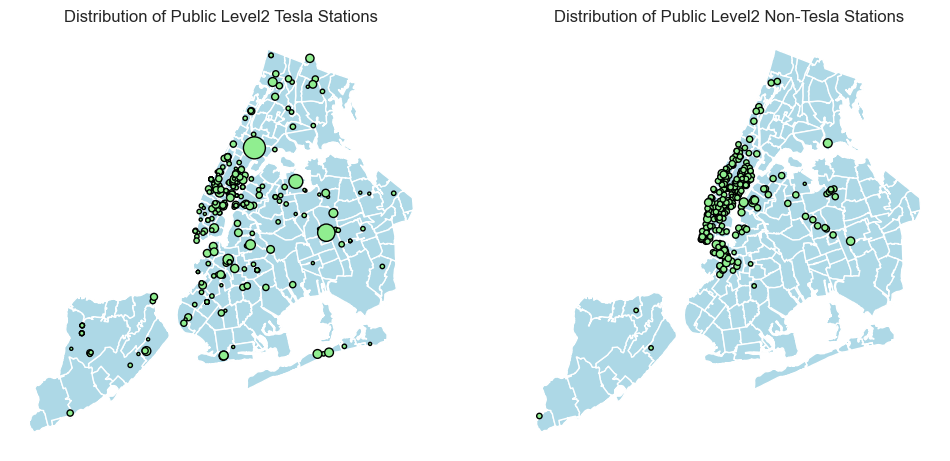

In [141]:
## Spatial Distribution
StationMap(zipcode, level2_ny, street)

PAY_GARAGE             226
HOTEL                   22
PARKING_LOT              9
CAR_DEALER               6
PARKING_GARAGE           5
OFFICE_BLDG              3
RESTAURANT               2
PUBLIC                   2
MULTI_UNIT_DWELLING      2
REC_SPORTS_FACILITY      1
STANDALONE_STATION       1
Name: facility_type, dtype: int64


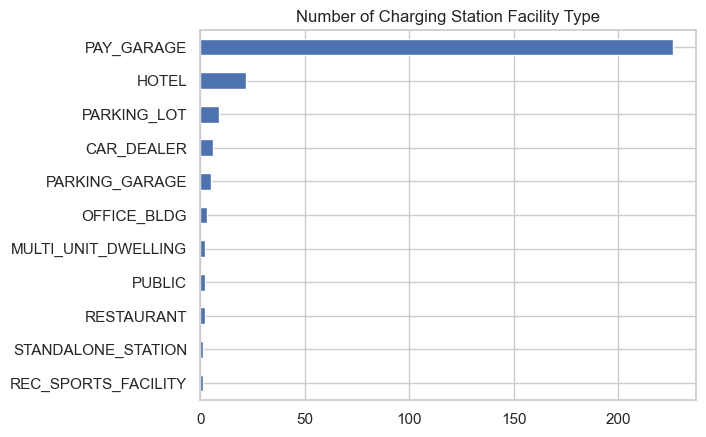

In [143]:
## Facility Type
print(level2_ny['facility_type'].value_counts())
level2_ny['facility_type'].value_counts().sort_values().plot.barh().set_title("Number of Charging Station Facility Type")
plt.show()

In [144]:
### hotel: most of charging stations in hotel belong to Tesla
level2_ny[level2_ny['facility_type']=='HOTEL'][['station_name','facility_type','zip','ev_connector_types',
                                                        'ev_level2_evse_num','ev_network']]

,station_name,facility_type,zip,ev_connector_types,ev_level2_evse_num,ev_network
168,Parkright 257 Gold Street - Tesla Destination,HOTEL,11201,"[J1772, TESLA]",3.0,Tesla Destination
170,Enterprise 309 Gold Street - Tesla Destination,HOTEL,11201,"[J1772, TESLA]",3.0,Tesla Destination
180,1 Hotel Brooklyn Bridge - Tesla Destination,HOTEL,11201,"[J1772, TESLA]",7.0,Tesla Destination
208,Hampton Inn LaGuardia Airport - Tesla Destination,HOTEL,11369,[TESLA],1.0,Tesla Destination
276,Rapidpark 124 W 20th Street - Tesla Destination,HOTEL,10011,"[J1772, TESLA]",3.0,Tesla Destination
279,New York Hilton Midtown - Tesla Destination,HOTEL,10019,[TESLA],2.0,Tesla Destination
290,Icon Parking 155 E 29th Street - Tesla Destina...,HOTEL,10016,"[J1772, TESLA]",3.0,Tesla Destination
299,Residence Inn New York Manhattan - Tesla Desti...,HOTEL,10019,"[J1772, TESLA]",2.0,Tesla Destination
302,iPark NYC 183 E 73rd Street - Tesla Destination,HOTEL,10021,"[J1772, TESLA]",3.0,Tesla Destination
345,Parkright 39 E 29th Street - Tesla Destination,HOTEL,10016,"[J1772, TESLA]",3.0,Tesla Destination
